# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlwpy_video_extras import easy_combo

In [2]:
from sklearn import (datasets,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     naive_bayes,
                     neighbors)

In [3]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Overfitting and Underfitting

### Synthetic Data

In [4]:
N = 20
ftr = np.linspace(-10, 10, num=N)                # ftr values
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N) # tgt = func(ftr)

(train_ftr, test_ftr,
 train_tgt, test_tgt) = skms.train_test_split(ftr, tgt, test_size=N//2)

display(pd.DataFrame({"ftr":train_ftr, 
                      "tgt":train_tgt}).T)

,0,1,2,3,4,5,6,7,8,9
ftr,-1.5789,-6.8421,-3.6842,1.5789,-7.8947,3.6842,7.8947,4.7368,5.7895,-0.5263
tgt,2.3906,91.0234,22.3791,3.8658,122.5817,22.9962,121.7528,40.6026,62.7696,-1.6137


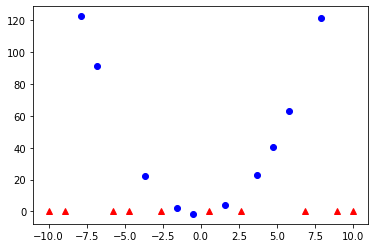

In [5]:
plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr,  np.zeros_like(test_ftr), 'r^');

### Varying Model Complexity

In [6]:
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1,1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1,1))
sk_preds[:3]

array([53.21803974, 41.45515945, 56.83738752])

In [7]:
# 1-degree polynomial is a line
model_one = np.poly1d(np.polyfit(train_ftr, train_tgt, 1))
preds_one = model_one(test_ftr)
print(preds_one[:3])

[53.21803974 41.45515945 56.83738752]


In [8]:
mse = metrics.mean_squared_error
print("RMSE:", np.sqrt(mse(test_tgt, preds_one)))

RMSE: 86.69151817350722


In [9]:
print("RMSE:", np.sqrt(mse(test_tgt, sk_preds)))

RMSE: 86.69151817350722


In [10]:
model_two = np.poly1d(np.polyfit(train_ftr, train_tgt, 2))
preds_two = model_two(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_two)))

RMSE: 1.2765992188881117


In [11]:
model_three = np.poly1d(np.polyfit(train_ftr, train_tgt, 9))
preds_three = model_three(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_three)))

RMSE: 317.3634424235501


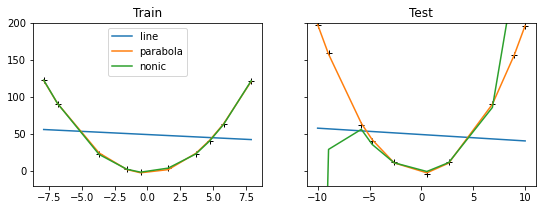

In [12]:
fig, axes = plt.subplots(1,2, figsize=(9,3), sharey=True)
train = (train_ftr, train_tgt)
test  = (test_ftr,  test_tgt)

labels = ['line', 'parabola', 'nonic']
models = [model_one, model_two, model_three]

for ax, (ftr, tgt) in zip(axes, [train, test]):
    ax.plot(ftr, tgt, 'k+')
    for m, lbl in zip(models, labels):
        ftr = sorted(ftr)
        ax.plot(ftr, m(ftr), '-', label=lbl)

axes[1].set(title='Test', ylim=(-20, 200))
axes[0].set(title="Train")
axes[0].legend(loc='upper center');

### Underfit and Overfit

In [13]:
results = []
for complexity in [1,2,6,9]:
    model = np.poly1d(np.polyfit(train_ftr, train_tgt, complexity))
    
    train_error = np.sqrt(mse(train_tgt, model(train_ftr)))
    test_error  = np.sqrt(mse(test_tgt, model(test_ftr)))
    
    results.append((complexity, train_error, test_error))

columns = ["Complexity", "Train Error", "Test Error"]
results_df = pd.DataFrame.from_records(results, 
                                       columns=columns,
                                       index="Complexity")

results_df

,Train Error,Test Error
Complexity,,
1,45.4951,86.6915
2,1.0828,1.2766
6,0.2819,6.1417
9,0.0000,317.3634


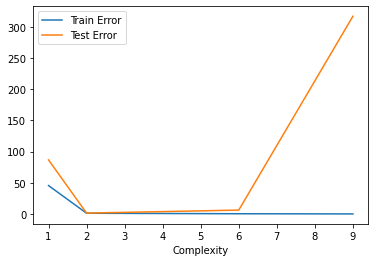

In [14]:
results_df.plot();

# Errors and Costs

In [15]:
def training_loss(single_loss, model, training_data):
    ' total training_loss on train_data with model under single_loss'
    pred_act = ((model.predict(ftrs.reshape(1,-1)), tgt) 
                       for ftrs, tgt in training_data)
    return sum(single_loss(p,a) for p,a in pred_act)

def squared_error(prediction, actual):
    ' squared error on a single example '
    return (prediction-actual)**2

# could be used like:
# my_training_loss = training_loss(squared_error, model, training_data)

In [16]:
diabetes = datasets.load_diabetes()

In [17]:
knn   = neighbors.KNeighborsRegressor(n_neighbors=3)
fit   = knn.fit(diabetes.data, diabetes.target)

training_data = zip(diabetes.data, diabetes.target)
my_training_loss = training_loss(squared_error, 
                                 knn, 
                                 training_data)
print(my_training_loss)

[863792.33333333]


In [18]:
mse = metrics.mean_squared_error(diabetes.target,
                                 knn.predict(diabetes.data))
print(mse*len(diabetes.data)) # mean = sum / n

863792.3333333333


# Cross-Validation

In [19]:
# 3-fold CV:

# divide data into 3 buckets:  I, II, III

# 3 rounds with different train-test sets:
#           test on     train on
# round 1:     I             II & III
# round 2:     II        I &      III
# round 3:     III       I & II

# we can do that for k-folds: 3, 5, 10, etc.

In [20]:
model = neighbors.KNeighborsRegressor(10)
skms.cross_val_score(model, 
                     diabetes.data, 
                     diabetes.target,
                     cv=5,
                     scoring='neg_mean_squared_error')

array([-3206.7541573 , -3426.43134831, -3587.94215909, -3039.49443182,
       -3282.60159091])

In [21]:
# iris is a classification problem
iris = datasets.load_iris() 
model = neighbors.KNeighborsClassifier(10)
skms.cross_val_score(model, iris.data, iris.target, cv=5)

array([0.96666667, 1.        , 1.        , 0.93333333, 1.        ])

# Leave-One-Out (LOO) Cross-Validation

In [22]:
# CV with maximum number of buckets:  N buckets
# train on all data but one example, test on that one example
# repeat N times
linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

loo = skms.LeaveOneOut()
scores = skms.cross_val_score(linreg, 
                              diabetes.data, diabetes.target,
                              cv=loo, 
                              scoring='neg_mean_squared_error')

rmse = pd.Series(np.sqrt(-scores))
df = pd.DataFrame({'RMSE':rmse})
df.index.name = 'Repeat'
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
RMSE,442.0000,44.3557,32.1973,0.2075,18.4820,39.5472,63.9738,158.2355


In [23]:
len(rmse) == len(diabetes.data)

True

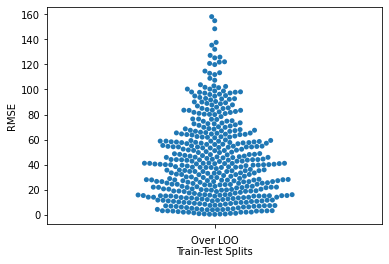

In [24]:
ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over LOO\nTrain-Test Splits');

# Stratification

In [25]:
# not stratified
pet = np.array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog'])
list_folds = list(skms.KFold(2).split(pet))
training_idxs = np.array(list_folds)[:,0,:]

print(pet[training_idxs])

[['dog' 'dog' 'dog']
 ['cat' 'dog' 'cat']]


In [26]:
pet = np.array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog'])
idxs = np.array(list(skms.StratifiedKFold(2)
                         .split(np.ones_like(pet), pet)))
training_idxs = idxs[:,0,:]
print(pet[training_idxs])

[['cat' 'dog' 'dog']
 ['cat' 'dog' 'dog']]


In [27]:
# running non-stratified CV
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)

non_strat_kf = skms.KFold(5)
skms.cross_val_score(model, 
                     iris.data, 
                     iris.target, 
                     cv=non_strat_kf)

array([1.        , 1.        , 0.86666667, 0.96666667, 0.76666667])

# Repeated Train-Test Splitting

In [28]:
# in cross-validation, every example is in one (and only one) test bucket
# with RTTS, examples can be (likely are) in multiple test sets
def tts_fit_eval(model, data, msr, test_size=.25):
    ' apply a train-test split to fit model on data and eval with msr '
    tts = skms.train_test_split(data.data, 
                                data.target, 
                                test_size=test_size)

    (train_ftrs, test_ftrs, train_tgt,  test_tgt) = tts
    
    fit   = model.fit(train_ftrs, train_tgt)
    preds = fit.predict(test_ftrs)

    result = msr(test_tgt, preds)
    return result

In [29]:
linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

mses = []
for r in range(10):
    mse = tts_fit_eval(linreg, 
                       diabetes, 
                       metrics.mean_squared_error)
    mses.append(mse)
# or for Python-ninjas:
# mses = [tts_fit_score(... as above ...) for i in range(10)]
    
    
rmses = pd.Series(np.sqrt(sorted(mses)))
df_man = pd.DataFrame({'RMSE':rmses})
df_man.index.name = 'Repeat'
display(df_man.T)

Repeat,0,1,2,3,4,5,6,7,8,9
RMSE,49.0032,50.1912,51.9735,52.0722,53.2005,55.7008,56.2542,57.4917,58.6379,58.6942


,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,54.3219,3.5058,49.0032,51.9982,54.4507,57.1823,58.6942


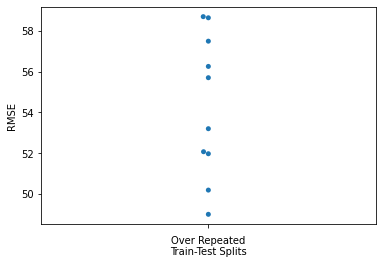

In [30]:
ax = sns.swarmplot(y='RMSE', data=df_man)
ax.set_xlabel('Over Repeated\nTrain-Test Splits')
display(df_man.describe().T)

,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,55.2028,2.4023,52.5422,54.0341,54.7754,55.6287,61.3167


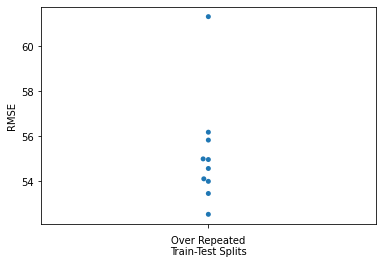

In [31]:
# RTTS using sklearn builtins 
linreg = linear_model.LinearRegression()

ss = skms.ShuffleSplit(test_size=.25) # default is .1 (10 splits)
scores = skms.cross_val_score(linreg, 
                              diabetes.data, diabetes.target,
                              cv=ss, 
                              scoring='neg_mean_squared_error')

# convert to -MSE to RMSE
rmses = pd.Series(np.sqrt(-scores))
df_sk = pd.DataFrame({'RMSE':rmses})
df_sk.index.name = 'Repeat'

display(df_sk.describe().T)

ax = sns.swarmplot(y='RMSE', data=df_sk)
ax.set_xlabel('Over Repeated\nTrain-Test Splits');

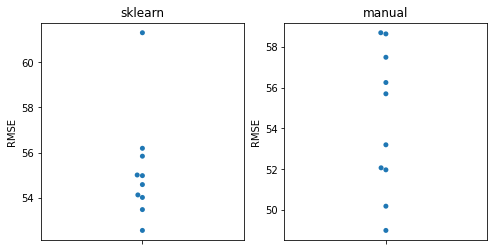

In [32]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.swarmplot(y='RMSE', data=df_sk,  ax=ax[0]).set_title('sklearn')
sns.swarmplot(y='RMSE', data=df_man, ax=ax[1]).set_title('manual');

# Learning and Complexity Curves

### Learning Curve

In [33]:
# learning curve tells us how our 
# performance changes with increasing data
iris = datasets.load_iris()

# 10 data set sizes:  10% - 100% 
# (that much data is piped to a 5-fold CV)
train_sizes = np.linspace(.1,1.0,10)
nn = neighbors.KNeighborsClassifier() # default 5 neighbors
num_folds = 5

(train_N, 
 train_scores, 
 test_scores) = skms.learning_curve(nn, 
                                    iris.data, iris.target, 
                                    cv=num_folds, 
                                    train_sizes=train_sizes)

# collapse across the 5 CV scores; one result for each data set size
df = pd.DataFrame(test_scores, index=(train_sizes*100).astype(np.int))
df['Mean 5-CV'] = df.mean(axis='columns')
df.index.name = "% Data Used"

display(df)

,0,1,2,3,4,Mean 5-CV
% Data Used,,,,,,
10,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
20,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
30,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
40,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
50,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
60,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
70,0.9000,0.8000,0.8333,0.8667,0.8000,0.8400
80,0.9667,0.9333,0.9000,0.9000,0.9667,0.9333
90,0.9667,1.0000,0.9000,0.9667,1.0000,0.9667


In [34]:
def sk_table_to_tidy(train_test_scores, # y values
                     eval_points,       # x values
                     eval_label,        # x column name
                     num_folds):        # could be inferred

    # construct row-by-row labels (a pct, train/test, fold)
    # and place in table
    labels = easy_combo(eval_points, 
                        [0,1], # surrogates for train/test 
                        np.arange(num_folds))
    df = pd.DataFrame.from_records(labels)
    df.columns = [eval_label, 'set', 'fold']
    df.set = df.set.replace({0:'Train', 1:'Test'})

    # construct the result (score) column
    train_scores, test_scores = train_test_scores
    score = np.concatenate([train_scores.flatten(), 
                            test_scores.flatten()], axis=0)    
    df['score'] = score
    return df

In [35]:
neat_sizes = (train_sizes*100).astype(np.int)
tidy_df = sk_table_to_tidy([train_scores, test_scores],
                           neat_sizes, 'pct', 5)
tidy_df.head()

,pct,set,fold,score
0,10,Train,0,1.0000
1,10,Train,1,1.0000
2,10,Train,2,1.0000
3,10,Train,3,1.0000
4,10,Train,4,1.0000


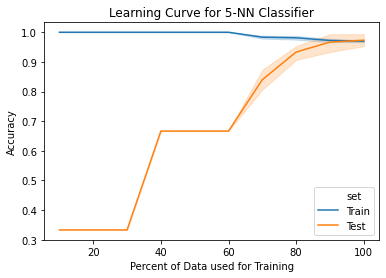

In [36]:
ax = sns.lineplot(x='pct', y='score', hue='set', data=tidy_df)
ax.set(title="Learning Curve for 5-NN Classifier",
       xlabel="Percent of Data used for Training",
       ylabel="Accuracy");

### Complexity Curve

In [37]:
# complexity (validation) curve tells us how our 
# performance changes with model complexity
n_neighbors = [1,3,5,10,15,20]
KNC = neighbors.KNeighborsClassifier
tt = skms.validation_curve(KNC(), 
                           iris.data, iris.target, 
                           param_name='n_neighbors',
                           param_range=n_neighbors,
                           cv=5)

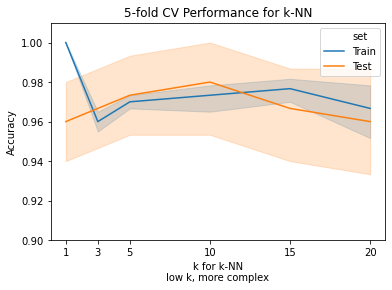

In [38]:
tidy_df = sk_table_to_tidy(tt, n_neighbors, 'k', 5)
ax = sns.lineplot(x='k', y='score', hue='set', data=tidy_df)

ax.set(title='5-fold CV Performance for k-NN',
       xlabel='k for k-NN\nlow k, more complex',
       xticks=n_neighbors,
       ylim=(.9, 1.01),
       ylabel='Accuracy');

# Graphical Cross-Validation

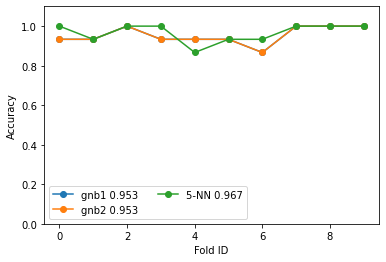

In [39]:
classifiers = {'gnb1' : naive_bayes.GaussianNB(),
               'gnb2' : naive_bayes.GaussianNB(),
               '5-NN' : neighbors.KNeighborsClassifier(n_neighbors=5)}

iris = datasets.load_iris()

fig, ax = plt.subplots(figsize=(6,4))
for name, model in classifiers.items():
    cv_scores = skms.cross_val_score(model, 
                                     iris.data, iris.target, 
                                     cv=10, 
                                     scoring='accuracy', 
                                     n_jobs=-1)
    my_lbl = "{} {:.3f}".format(name, cv_scores.mean())
    ax.plot(cv_scores, '-o', label=my_lbl)

ax.set(ylim=(0.0, 1.1), 
       xlabel='Fold ID', 
       ylabel='Accuracy')
ax.legend(ncol=2);